# Superstore Timeseries #

We'll try to solve a timeseries project. This notebook is a bit wordier than my previous ones.

## Introduction

It is a dataset about the products that customers bought on their store and the total amount over the time. From 2015 to 2019, almost completely. The orders were shipped, and we also have access to the shipping information.

As for the project itself, it's about timeseries, timeseries are vector values that have a timestamp on them, a date, most commonly, it could be by day, by hour, by seconds, by a combination of factors. The idea with timeseries is to, given **`N`** units of time (day, hours, seconds, etc.) predict the target value(s) for the next **`M`** units of time, it could be right after the last input unit of time, or **`O`** units after.

### Original Dataset

The official Dataset Page

- https://openml.org/search?type=data&status=active&id=43383&sort=runs

### References

The technical references used for this project, mainly.

- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook

## Initialization

We'll need some imports, and to download the dataset from the official OpenML's page. We'll import a function that already handles the process.

### Imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from typing import List
import datetime
import tensorflow as tf

import IPython
import IPython.display

### Download the dataset

It's a free dataset published on the official OpenML website

In [2]:
raw_dataset_response = fetch_openml(data_id=43383)

We must now parse the dataset fetch response

In [3]:
dataframe = raw_dataset_response['frame'].copy(deep=True)

And we'll assign the feature names

In [4]:
feature_names = raw_dataset_response['feature_names']

And we can now explore a little bit more the dataset

In [5]:
dataframe.head(5)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub-Category,Product_Name,Sales
0,1.0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2.0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3.0,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4.0,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5.0,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [6]:
dataframe.tail(5)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub-Category,Product_Name,Sales
9795,9796.0,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798
9796,9797.0,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368
9797,9798.0,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.188
9798,9799.0,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.376
9799,9800.0,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-AC-10000487,Technology,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384


## Data Preprocessing

From this section, the data will be ready for the model, well, almost, as ready as it can be, but all of the values will be ready to be computed.

### Backup

I always like to do a backup so I can always go back to this cell and re-execute it to got back to it's original state, or to execute all of the cells from here, knowing it'll do all of the transformations and trainings

In [7]:
df = dataframe.copy(deep=True)

### Standarization

We'll standarize all of the values so that they're all numeric and understandable by the computer

In [8]:
columns_to_factorize = [
  'Order_ID',
  'Ship_Mode',
  'Customer_ID',
  'Customer_Name',
  'Segment',
  'Country',
  'City',
  'State',
  'Region',
  'Product_ID',
  'Category',
  'Sub-Category',
  'Product_Name',
]

In [9]:
def factorize_column(
  column: str,
  df: pd.DataFrame = df
) -> None:
  if column not in df:
    print(f'"{column}" was not found in the dataframe')
    return

  df[column] = pd.factorize(df[column])[0]
  print(f'"{column}" was successfully factorized!')

_ = tuple(map(factorize_column, columns_to_factorize))

"Order_ID" was successfully factorized!
"Ship_Mode" was successfully factorized!
"Customer_ID" was successfully factorized!
"Customer_Name" was successfully factorized!
"Segment" was successfully factorized!
"Country" was successfully factorized!
"City" was successfully factorized!
"State" was successfully factorized!
"Region" was successfully factorized!
"Product_ID" was successfully factorized!
"Category" was successfully factorized!
"Sub-Category" was successfully factorized!
"Product_Name" was successfully factorized!


So that, after everything, we can now a datafram that looks like this

In [10]:
df.head(5)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub-Category,Product_Name,Sales
0,1.0,0,08/11/2017,11/11/2017,0,0,0,0,0,0,0,42420.0,0,0,0,0,0,261.9600
1,2.0,0,08/11/2017,11/11/2017,0,0,0,0,0,0,0,42420.0,0,1,0,1,1,731.9400
2,3.0,1,12/06/2017,16/06/2017,0,1,1,1,0,1,1,90036.0,1,2,1,2,2,14.6200
3,4.0,2,11/10/2016,18/10/2016,1,2,2,0,0,2,2,33311.0,0,3,0,3,3,957.5775
4,5.0,2,11/10/2016,18/10/2016,1,2,2,0,0,2,2,33311.0,0,4,1,4,4,22.3680


### Date standarization

We'll standarize the values so that they're understandable by the computer. And the date is no exception, but the how of it, it's a little bit different.

In [11]:
date_columns = [
  'Ship_Date',
  'Order_Date',
]

In [12]:
def standarize_date_columns(
  df_date: pd.DataFrame = df,
  columns: List[str] = date_columns,
  standarize_day: bool = False,
  standarize_year: bool = True,
  drop_columns: bool = False,
) -> pd.DataFrame:
  for column in columns:
    date_time = pd.to_datetime(df_date[column])
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    df_date[column] = timestamp_s

    day = 24 * 60 * 60
    year = (365.2425) * day

    if standarize_day:
      df_date[f'{column}_hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
      df_date[f'{column}_hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    if standarize_year:
      df_date[f'{column}_day_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
      df_date[f'{column}_day_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    if drop_columns:
      df_date = df_date.drop(columns=[column])
  
  return df_date

In [13]:
df = standarize_date_columns(df).copy(deep=True)

### Missing values

Null values, rows that have missing information, whether it be one attribute, or the whole row

In [14]:
df.isna().sum() * 100 / len(df)

Row_ID                0.000000
Order_ID              0.000000
Order_Date            0.000000
Ship_Date             0.000000
Ship_Mode             0.000000
Customer_ID           0.000000
Customer_Name         0.000000
Segment               0.000000
Country               0.000000
City                  0.000000
State                 0.000000
Postal_Code           0.112245
Region                0.000000
Product_ID            0.000000
Category              0.000000
Sub-Category          0.000000
Product_Name          0.000000
Sales                 0.000000
Ship_Date_day_sin     0.000000
Ship_Date_day_cos     0.000000
Order_Date_day_sin    0.000000
Order_Date_day_cos    0.000000
dtype: float64

In [15]:
df.isna().sum().sum() / (len(df) * len(feature_names))

6.235827664399093e-05

In [16]:
len(df)

9800

In [17]:
df.dropna(subset=['Postal_Code'], inplace=True)
len(df)

9789

### Abnormal values

Any value that does not make sense, or that it's too weird, negative values where they shouldn't be, always the same value, etc.

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row_ID,9789.0,4.896706e+03,2.827487e+03,1.000000e+00,2.449000e+03,4.896000e+03,7.344000e+03,9.800000e+03
Order_ID,9789.0,2.429214e+03,1.416475e+03,0.000000e+00,1.204000e+03,2.420000e+03,3.654000e+03,4.921000e+03
Order_Date,9789.0,1.492000e+09,3.621613e+07,1.420157e+09,1.462061e+09,1.496102e+09,1.523405e+09,1.546128e+09
Ship_Date,9789.0,1.492793e+09,3.627058e+07,1.420330e+09,1.462579e+09,1.497226e+09,1.525306e+09,1.556669e+09
Ship_Mode,9789.0,1.069057e+00,7.501067e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
Customer_ID,9789.0,3.638326e+02,2.233592e+02,0.000000e+00,1.700000e+02,3.510000e+02,5.550000e+02,7.920000e+02
Customer_Name,9789.0,3.638326e+02,2.233592e+02,0.000000e+00,1.700000e+02,3.510000e+02,5.550000e+02,7.920000e+02
Segment,9789.0,6.576770e-01,7.627057e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
Country,9789.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
City,9789.0,9.985320e+01,1.237838e+02,0.000000e+00,1.200000e+01,4.000000e+01,1.460000e+02,5.280000e+02


Country was a weird one, all zeros

In [19]:
df['Country'].unique()

array([0])

If it's always going to be the same, might aswell not be there

In [20]:
df = df.drop(columns=['Country'])

### Correlation

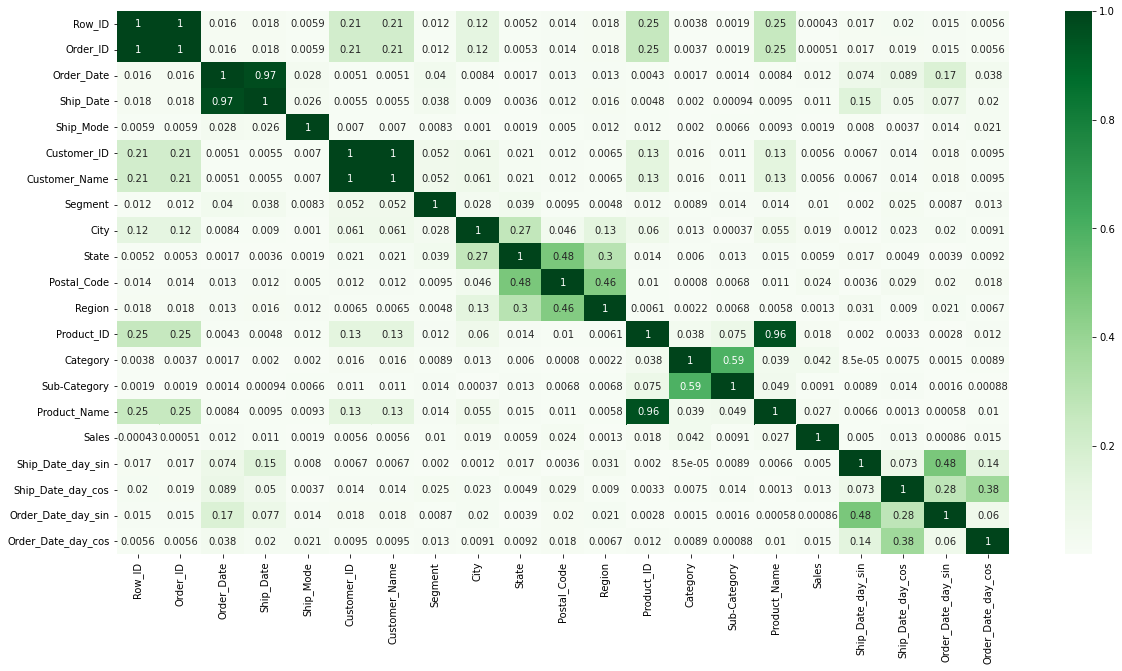

In [21]:
plt.figure(figsize=(20, 10))
_ = sns.heatmap(df.corr().abs(), annot=True, fmt='.2g', cmap='Greens')

Let's remove some highly correlated values

In [22]:
df = df.drop(columns=[
  'Row_ID',
  'Product_Name',
  'Customer_Name',
])

And see each correlation towards our target

In [23]:
df.corr()[['Sales']].transpose()

,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Segment,City,State,Postal_Code,Region,Product_ID,Category,Sub-Category,Sales,Ship_Date_day_sin,Ship_Date_day_cos,Order_Date_day_sin,Order_Date_day_cos
Sales,-0.000508,-0.012269,-0.010833,-0.001905,0.005622,0.010304,-0.018778,0.005871,-0.024067,-0.001272,0.017881,0.042443,-0.009073,1.0,0.004966,0.013193,0.000856,0.014513


## Exploratory Data Analysis

On the official dataset page we already get an overview, but we'll do the step-by-step by the book, or so to speak...

But, beforehand, let's create some temporal dataframes that we need.

In [24]:
df_exploratory = df.copy(deep=True).sort_values('Order_Date', ascending=True)[:2000]

In [25]:
df_sorted_by_order = df.copy(deep=True).sort_values('Order_Date', ascending=True)[:2000]
df_sorted_by_order_no_limit = df.copy(deep=True).sort_values('Order_Date', ascending=True)
df_sorted_by_ship = df.copy(deep=True).sort_values('Ship_Date', ascending=True)[:2000]
df_sorted_by_ship_no_limit = df.copy(deep=True).sort_values('Ship_Date', ascending=True)

### Dates sanity check

We're checking that the loop is how it should be, intertwined with each other following an eternal pattern

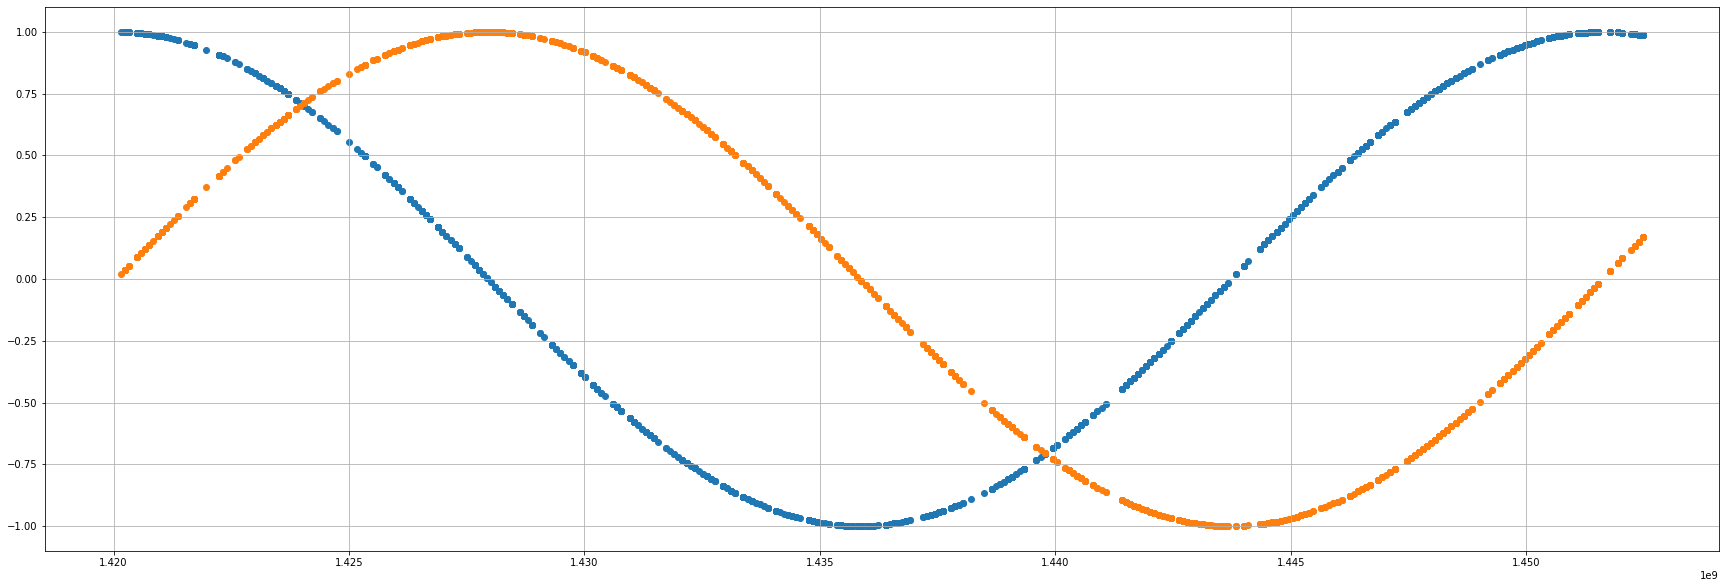

In [26]:
plt.figure(figsize=(30, 10))
plt.grid()
plt.scatter(df_exploratory['Order_Date'], df_exploratory['Order_Date_day_cos'])
plt.scatter(df_exploratory['Order_Date'], df_exploratory['Order_Date_day_sin'])

Let's first get a sneak peek at what the actual time series of order and shipping looks like

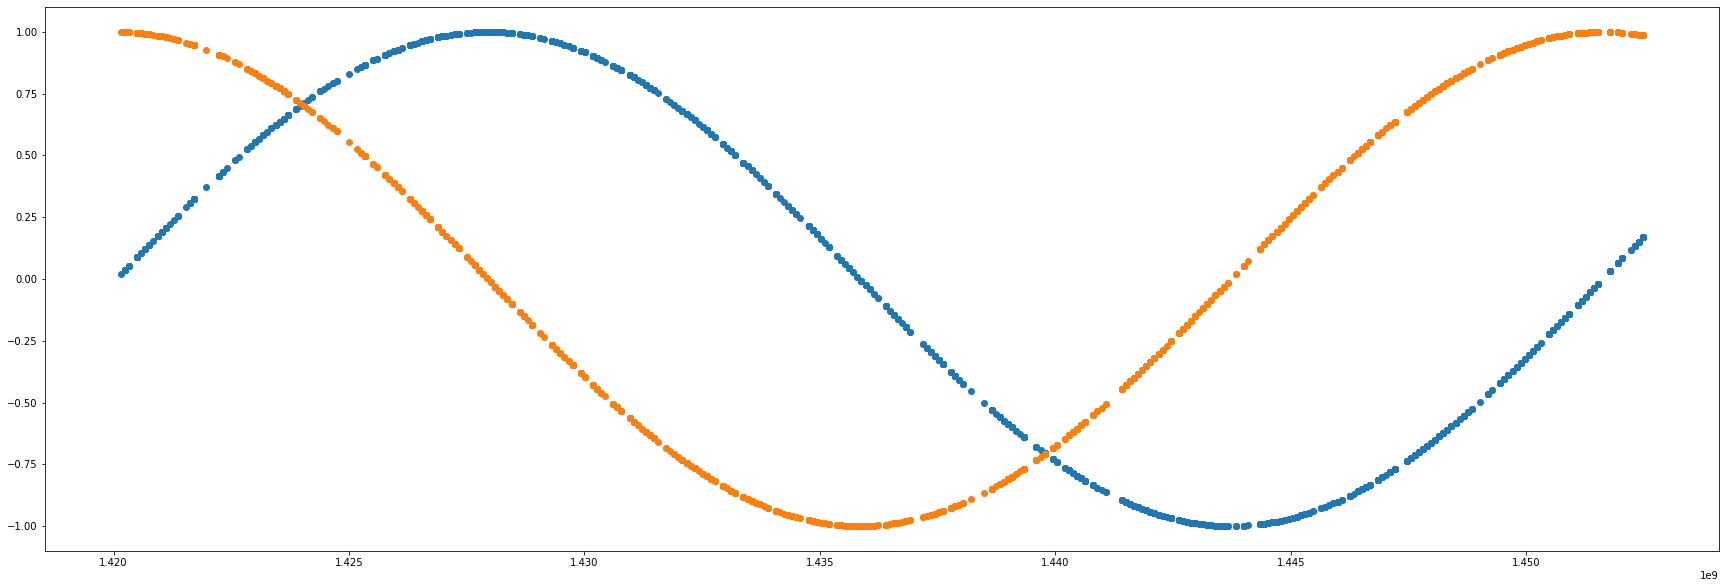

In [27]:
plt.figure(figsize=(30, 10))
_ = plt.scatter(df_exploratory['Order_Date'], df_exploratory['Order_Date_day_sin'], label='sin')
_ = plt.scatter(df_exploratory['Order_Date'], df_exploratory['Order_Date_day_cos'], label='cos')

The same plot as before, but with a line instead of scattered points

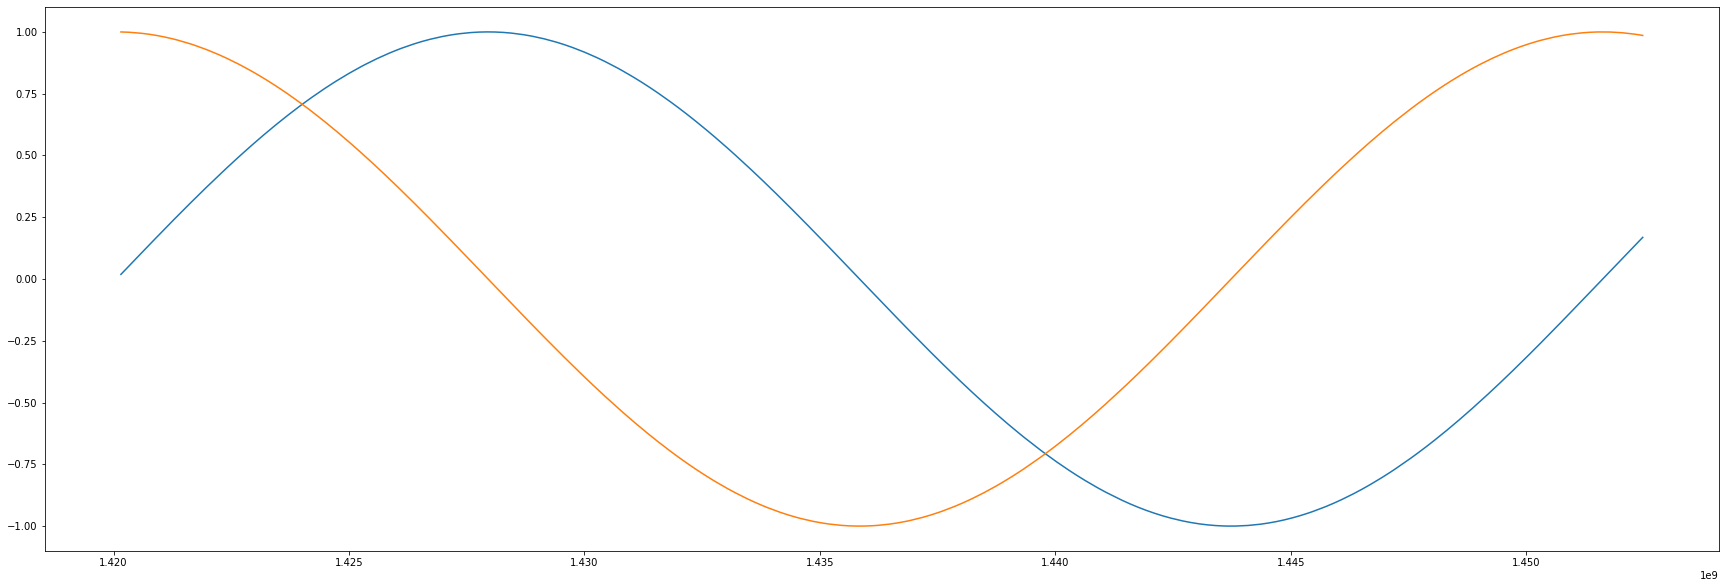

In [28]:
plt.figure(figsize=(30, 10))
_ = plt.plot(df_exploratory['Order_Date'], df_exploratory['Order_Date_day_sin'], label='sin')
_ = plt.plot(df_exploratory['Order_Date'], df_exploratory['Order_Date_day_cos'], label='cos')

### Full scope of the date values

It can allow us to see frequency, quite quickly, incosistency, if there's any sort of error or infromation loss (even though we'll do that later).

Here, what's important is that we can detect any anomaly in the transformation. If done properly, it should be looping just fine. But, as we can clearly observe, shipping date does not loop perfectly towards it's end, most likely because of the wider range of dates.

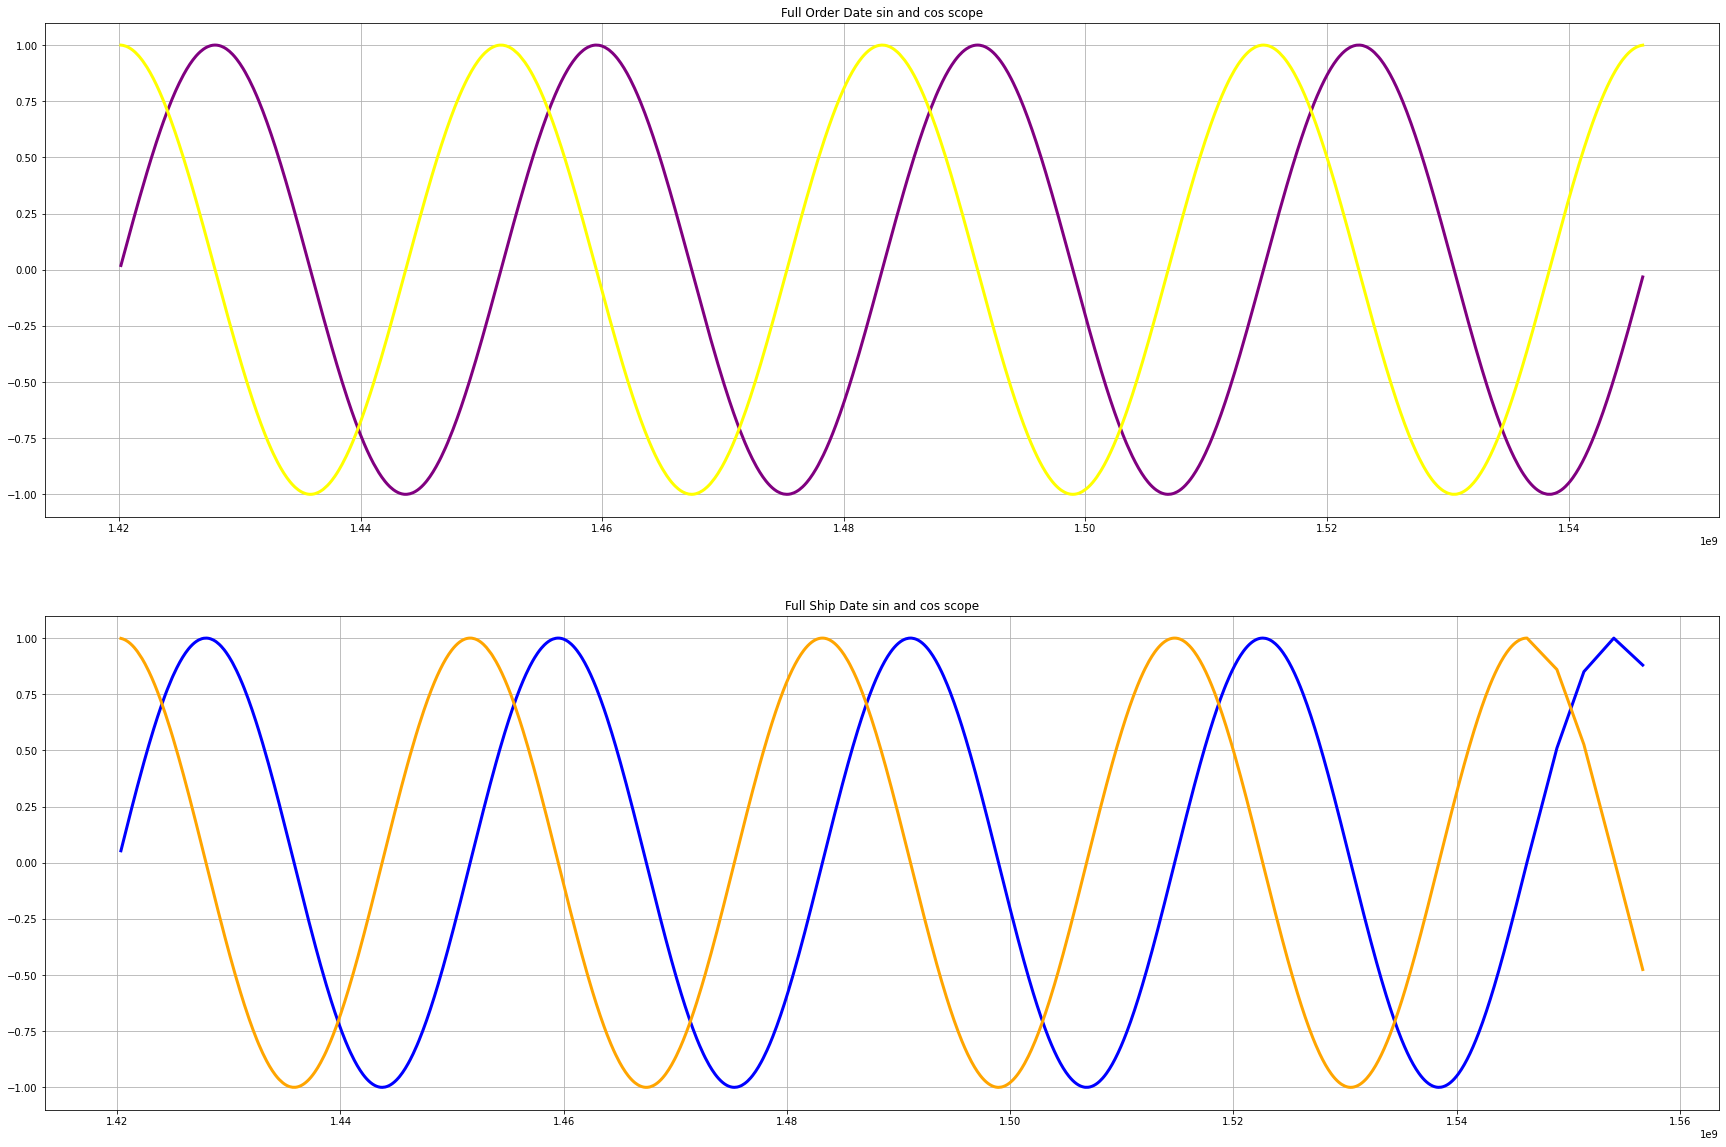

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))
# alpha = .02
# alpha = .15
alpha = 1
lw = 3

axes[0].grid()
axes[0].set_title('Full Order Date sin and cos scope')
axes[0].plot(df_sorted_by_order_no_limit['Order_Date'], df_sorted_by_order_no_limit['Order_Date_day_sin'], label='order_sin', color='purple', alpha=alpha, lw=lw)
axes[0].plot(df_sorted_by_order_no_limit['Order_Date'], df_sorted_by_order_no_limit['Order_Date_day_cos'], label='order_cos', color='yellow', alpha=alpha, lw=lw)

axes[1].grid()
axes[1].set_title('Full Ship Date sin and cos scope')
axes[1].plot(df_sorted_by_ship_no_limit['Ship_Date'], df_sorted_by_ship_no_limit['Ship_Date_day_sin'], label='ship_sin', color='blue', alpha=alpha, lw=lw)
axes[1].plot(df_sorted_by_ship_no_limit['Ship_Date'], df_sorted_by_ship_no_limit['Ship_Date_day_cos'], label='ship_cos', color='orange', alpha=alpha, lw=lw)

_ = None

### Order and Shipping dates disparity

The shipping date sorted by order date

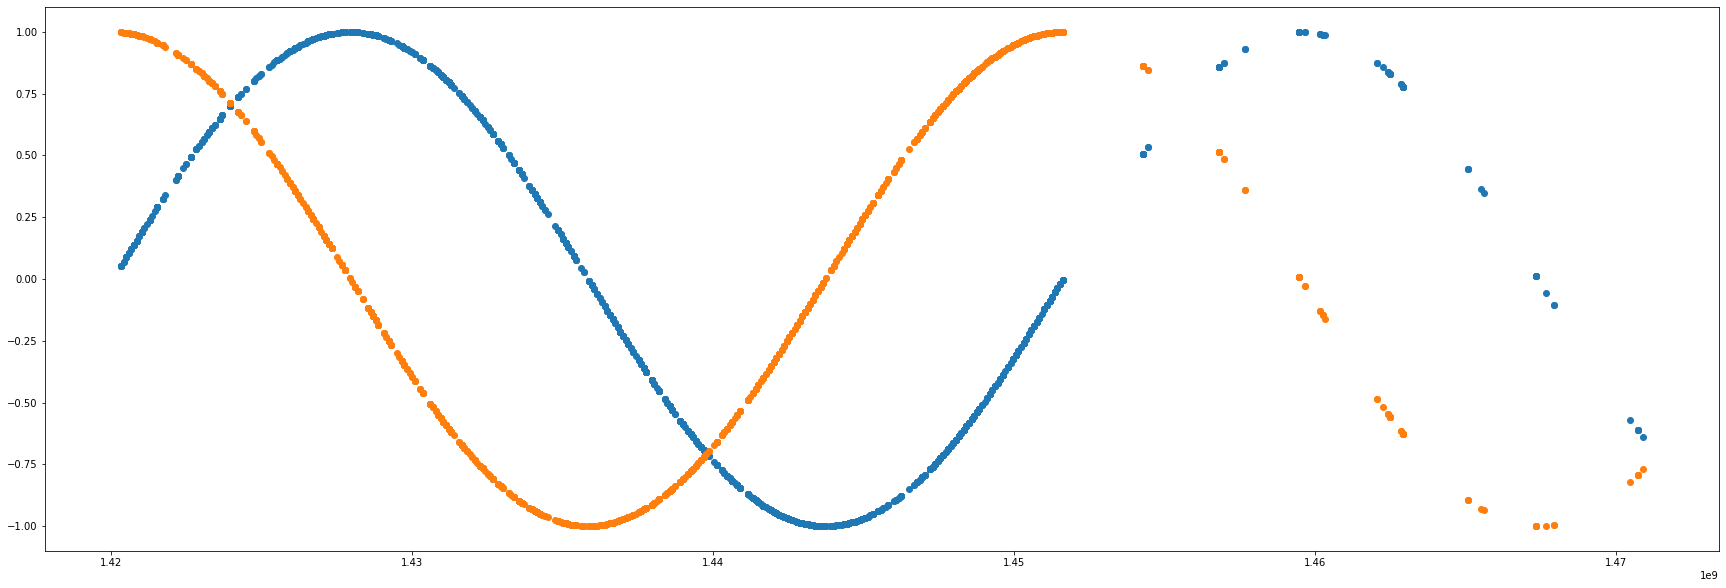

In [30]:
plt.figure(figsize=(30, 10))
_ = plt.scatter(df_exploratory['Ship_Date'], df_exploratory['Ship_Date_day_sin'], label='sin')
_ = plt.scatter(df_exploratory['Ship_Date'], df_exploratory['Ship_Date_day_cos'], label='cos')

With shipping, the shape it's there, but with so much information loss, is as if it were loss

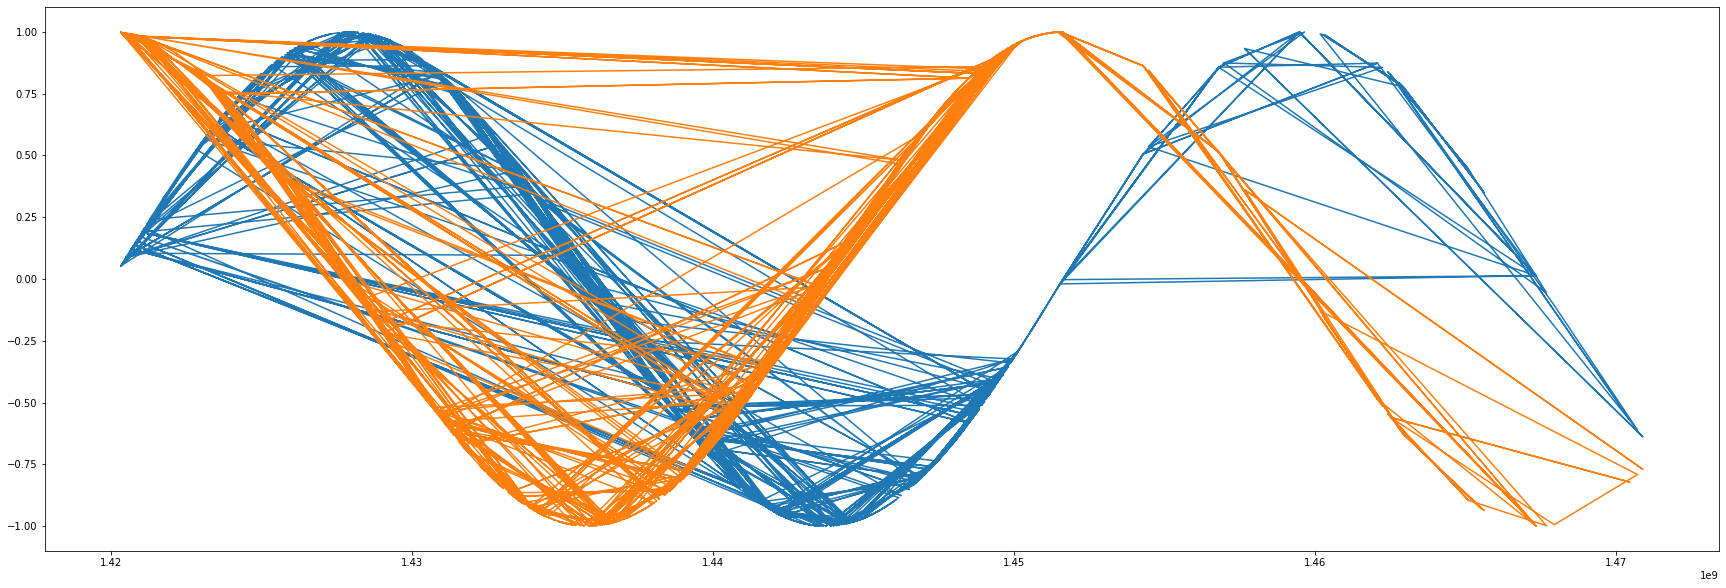

In [31]:
plt.figure(figsize=(30, 10))
_ = plt.plot(df_exploratory['Ship_Date'], df_exploratory['Ship_Date_day_sin'], label='sin')
_ = plt.plot(df_exploratory['Ship_Date'], df_exploratory['Ship_Date_day_cos'], label='cos')

When the shipping date is ordered by the order date, surprisingly, we get that order and shipping barely happened on the same day, let's not talk about close, just the same day.

Which is confusing to visualize.

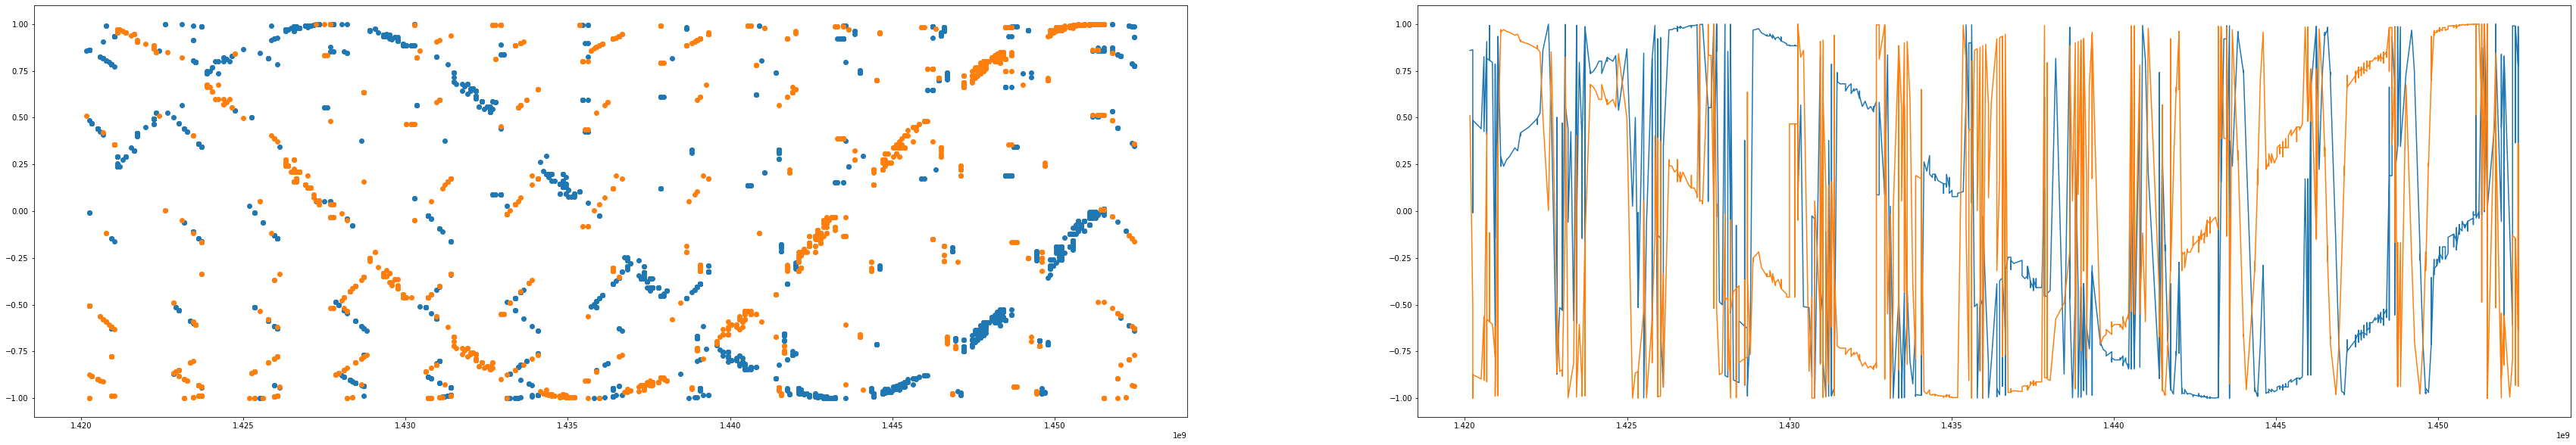

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(30 * 2, 10))
_ = axes[1].plot(df_exploratory['Order_Date'], df_exploratory['Ship_Date_day_sin'], label='sin')
_ = axes[1].plot(df_exploratory['Order_Date'], df_exploratory['Ship_Date_day_cos'], label='cos')
_ = axes[0].scatter(df_exploratory['Order_Date'], df_exploratory['Ship_Date_day_sin'], label='sin')
_ = axes[0].scatter(df_exploratory['Order_Date'], df_exploratory['Ship_Date_day_cos'], label='cos')

### Information loss in the dates values

And now all of them together

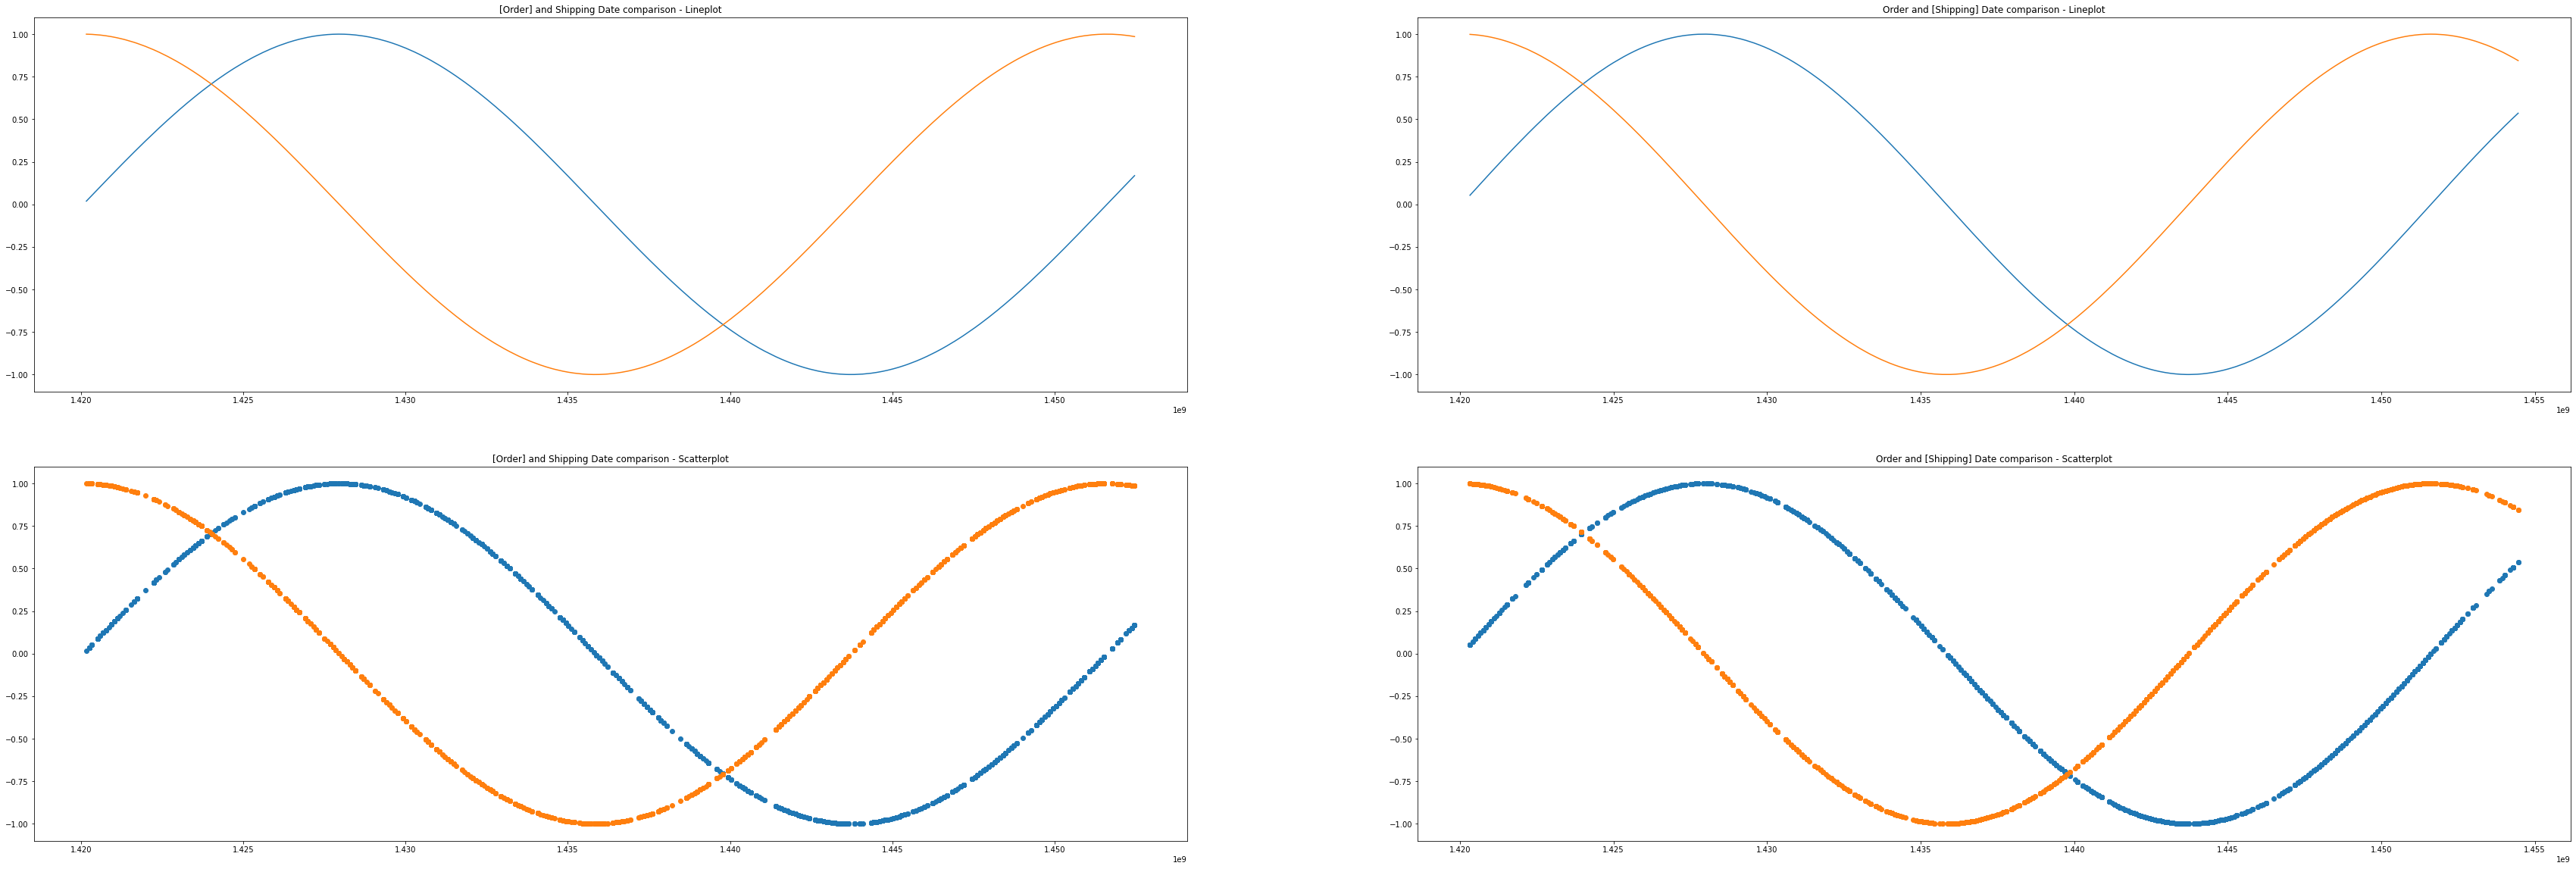

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(30 * 2, 10 * 2))
# fig.suptitle('Order and Shipping Date comparison')

# first row
axes[0, 0].set_title('[Order] and Shipping Date comparison - Lineplot')
_ = axes[0, 0].plot(df_sorted_by_order['Order_Date'], df_sorted_by_order['Order_Date_day_sin'], label='order_sin')
_ = axes[0, 0].plot(df_sorted_by_order['Order_Date'], df_sorted_by_order['Order_Date_day_cos'], label='order_cos')
axes[0, 1].set_title('Order and [Shipping] Date comparison - Lineplot')
_ = axes[0, 1].plot(df_sorted_by_ship['Ship_Date'], df_sorted_by_ship['Ship_Date_day_sin'], label='ship_sin')
_ = axes[0, 1].plot(df_sorted_by_ship['Ship_Date'], df_sorted_by_ship['Ship_Date_day_cos'], label='ship_cos')

# second row
axes[1, 0].set_title('[Order] and Shipping Date comparison - Scatterplot')
_ = axes[1, 0].scatter(df_sorted_by_order['Order_Date'], df_sorted_by_order['Order_Date_day_sin'], label='order_sin')
_ = axes[1, 0].scatter(df_sorted_by_order['Order_Date'], df_sorted_by_order['Order_Date_day_cos'], label='order_cos')
axes[1, 1].set_title('Order and [Shipping] Date comparison - Scatterplot')
_ = axes[1, 1].scatter(df_sorted_by_ship['Ship_Date'], df_sorted_by_ship['Ship_Date_day_sin'], label='ship_sin')
_ = axes[1, 1].scatter(df_sorted_by_ship['Ship_Date'], df_sorted_by_ship['Ship_Date_day_cos'], label='ship_cos')

We can conclude that there's information loss between dates, which means that, not all days have sales.

### Sales cyclic pattern detection

And now let's see if, over the time, there's any sort of pattern in the sales, a pattern overtime. We can do an analysis to detect any sort of repeating pattern.

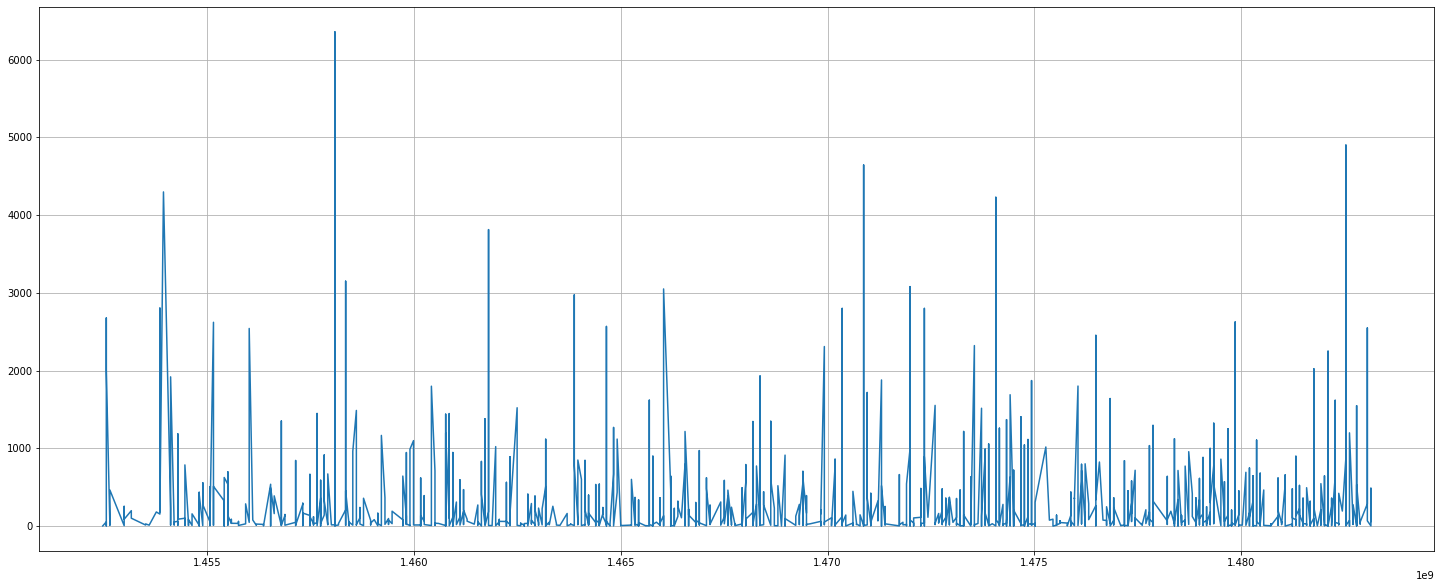

In [34]:
plt.figure(figsize=(25, 10))
plot_features = (
  df[[
    'Sales',
    'State',
    'Order_Date',
  ]]
  .copy(deep=True)
  .sort_values(by='Order_Date')
)
plot_features = plot_features[2_000:4_000]
plt.grid()
_ = plt.plot(
  plot_features['Order_Date'],
  plot_features['Sales'],
)

The total framing of the sales, in a much wider plot

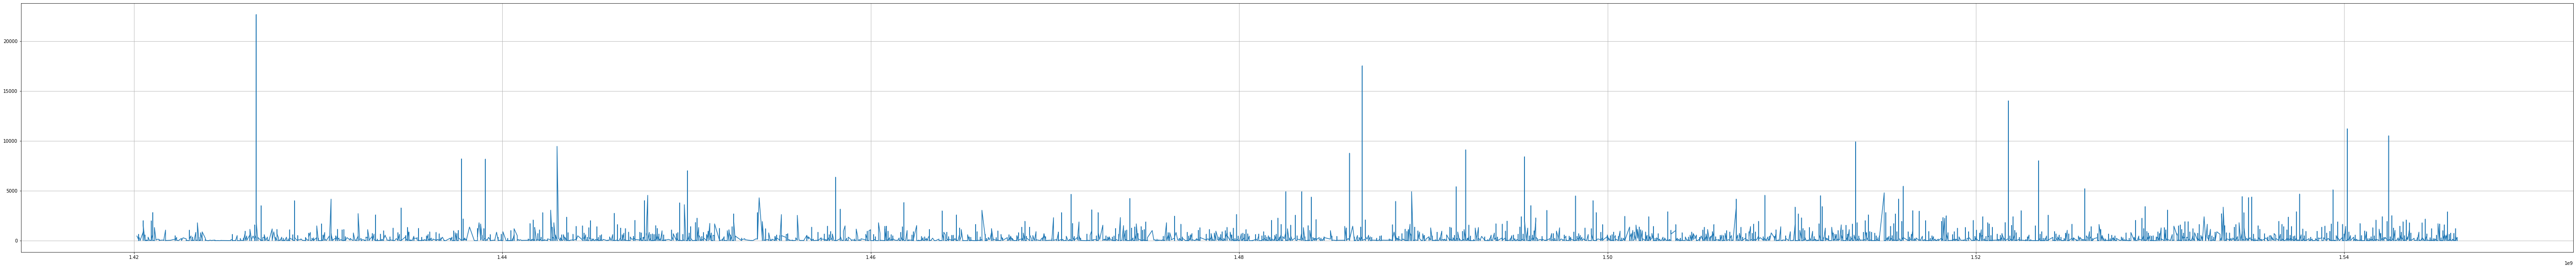

In [35]:
plt.figure(figsize=(100, 10))
plot_features = (
  df[[
    'Sales',
    'State',
    'Order_Date',
  ]]
  .copy(deep=True)
  .sort_values(by='Order_Date')
)
plt.grid()
plot_features = plot_features
_ = plt.plot(
  plot_features['Order_Date'],
  plot_features['Sales'],
)

There's no pattern it seems, it looks like it may be too complex to solve, for my current level at least.

They only sort of pattern happens every quarter of the picture where there may be a denser area, but it's not a given

We can even render with less steps to see any predominant pattern which may help reduce the noise of having too many information

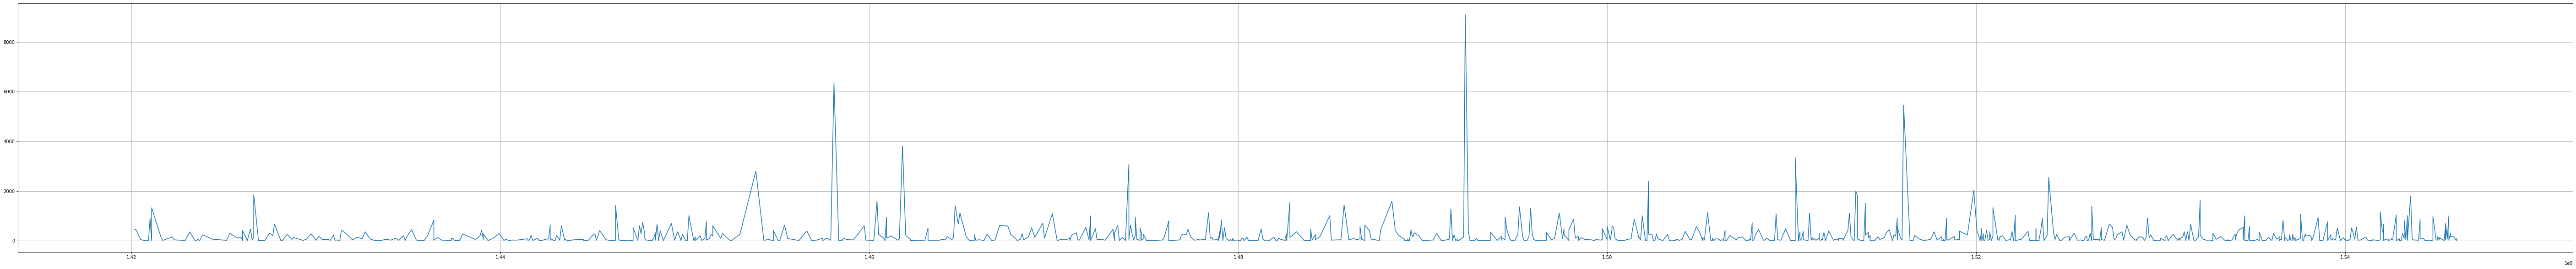

In [36]:
plt.figure(figsize=(100, 10))
plot_features = (
  df[[
    'Sales',
    'State',
    'Order_Date',
  ]]
  .copy(deep=True)
  .sort_values(by='Order_Date')
)
steps = 10
plt.grid()
plot_features = plot_features[::steps]
_ = plt.plot(
  plot_features['Order_Date'],
  plot_features['Sales'],
)

The sorted sales

In [37]:
plot_features.sort_values(by='Order_Date')['Sales']

540     468.900
157     457.568
246      47.880
1837     17.544
8705      4.710
         ...   
2423    158.928
2569    164.388
4287     64.784
7633     12.530
5131    101.120
Name: Sales, Length: 979, dtype: float64

## Data Preparation

We must get the data ready for our Timeseries nueral network

In [38]:
df = df.sort_values(by='Order_Date', ascending=False)

In [39]:
target = 'Sales'
ignore_columns = [
  # target,
  'Order_Date',
  'Ship_Date',
  # 'Ship_Date_day_sin',
  # 'Ship_Date_day_cos',
  # 'Order_ID',
  # 'Customer_ID',
]
train_columns = ( col for col in df.columns if col not in ignore_columns )

### Splitting

We should have three sets, optimally:

- Train
- Validation
- Test

It is crucial they're in chronological order

In [40]:
column_indices = {name: i for i, name in enumerate(df.columns)}

temp_df = df[train_columns].copy(deep=True)

start_index = 0
start_index = 2_000
start_index = 3_000
temp_df = temp_df[start_index:]

n = len(temp_df)
train_df = temp_df[0:int(n*0.7)]
val_df = temp_df[int(n*0.7):int(n*0.9)]
test_df = temp_df[int(n*0.9):]

num_features = temp_df.shape[1]

### Normalization

All of the values should be between zero and one from this point forward

In [41]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Standarized visualization

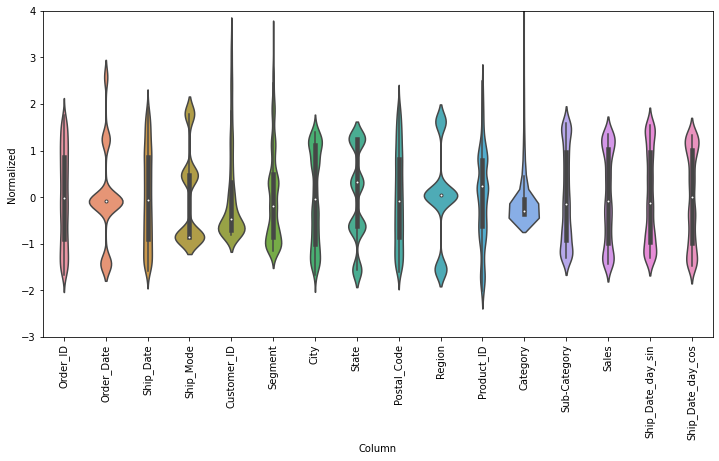

In [42]:
df_std = train_df
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
plt.ylim(-3, 4)
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Since the training is what happened before, it displays bigger deviations, as it is as the dataset grows that the sales do so. So we end up having, for what's the norm, huge deviations.

That is, if we apply the standard normalization, as suggested by the Tensorflow doc (suggested for their given dataset)

Meaning, we have to to min max normalization ourselves

In [43]:
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
test_df = (test_df - train_min) / (train_max - train_min)

So we can have something more along the lines of:

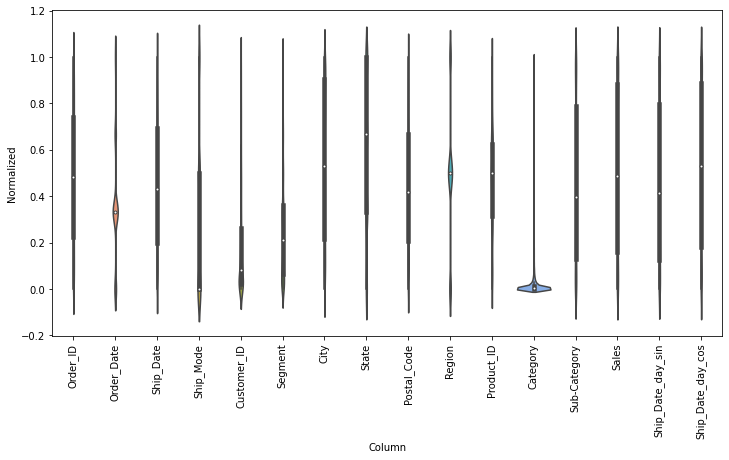

In [44]:
df_std = train_df
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Here we still have values outside the preferred range of (0, 1), but it's not as huge of a deviation as with the standard normalization.

## WindowGenerator

Straight from the Tensorflow page, used to split the data into window so that our model can train

In [45]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### Split window

The actual generation of the windows

In [46]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Plot

Plot a comparisonof how well did the model performed

In [47]:
def plot(self, model=None, plot_col=target, max_subplots=3, figsize=(12, 8), xlim=None):
  inputs, labels = self.example
  plt.figure(figsize=figsize)
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    if xlim:
      plt.xlim(*xlim)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    if xlim:
      plt.xlim(*xlim)
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      if xlim:
        plt.xlim(*xlim)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

### Make Dataset

Creates a Tensor from a given array

In [48]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

### Split datasets

Creates and returns the different sets of data

In [49]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Window generations

We'll need them to train and predict with our model.

In [50]:
OUT_STEPS = 7 #@param {type: 'integer'}

### Single Step Window

The single-step window just expects one input row, to output one row (with one attribute for this project)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Sales']

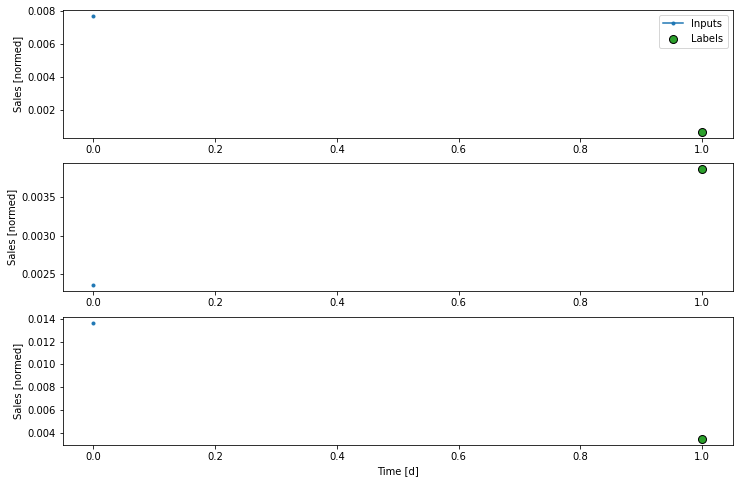

In [51]:
single_step_window = WindowGenerator(
  input_width=1,
  label_width=1,
  shift=1,
  label_columns=[target,],
)

single_step_window.plot()
single_step_window

### Wide window

The wide-window has a wider input to output as many rows as we want, in this case, we'll use a whole semester to predict the next week

Total window size: 127
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126]
Label column name(s): ['Sales']

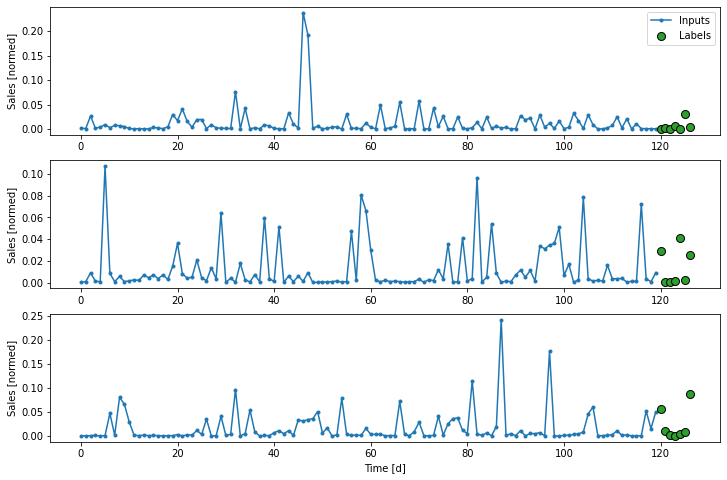

In [52]:
wide_window = WindowGenerator(
  input_width=4 * 30,
  # input_width=7,
  # input_width=OUT_STEPS * 5,
  label_width=OUT_STEPS,
  shift=OUT_STEPS,
  label_columns=[target,],
)

wide_window.plot()
wide_window

### Multi window

Same input than output

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

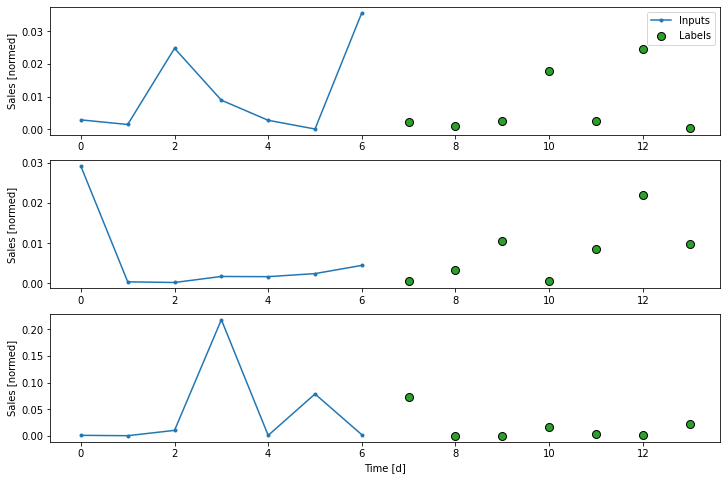

In [53]:
multi_window = WindowGenerator(
  input_width=OUT_STEPS,
  label_width=OUT_STEPS,
  shift=OUT_STEPS
)

multi_window.plot()
multi_window

## Forecasting

It's time for the challenges. You can forecast in various different manners, with variations:

- Single/Multiple inputs.
- That can predict single/multiple outputs.
- Containing single/multiple attributes.

In our case, we'll use a **multiple** input to predict **multiple** output with a **single** attribute (the sales).

### Multi-step prediction challenge

The proposed challenge, a single output variable with multi-step. To predict the next 7 days after the whole dataset.

### Compile the model

Compiling and fitting the model, all at once

In [54]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2, epochs=MAX_EPOCHS):
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min'
  )

  model.compile(
    loss=tf.losses.MeanSquaredError(),
    # loss='mape', # recomended as an accuracy metric
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
    window.train,
    epochs=epochs,
    validation_data=window.val,
    callbacks=[early_stopping]
  )

  return history

### Multi-step Baseline

This one is just for showcasing purposes, it's actually a dummy one.

It repeats the last given value.

In [55]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(
  loss=tf.losses.MeanSquaredError(),
  metrics=[tf.metrics.MeanAbsoluteError()]
)


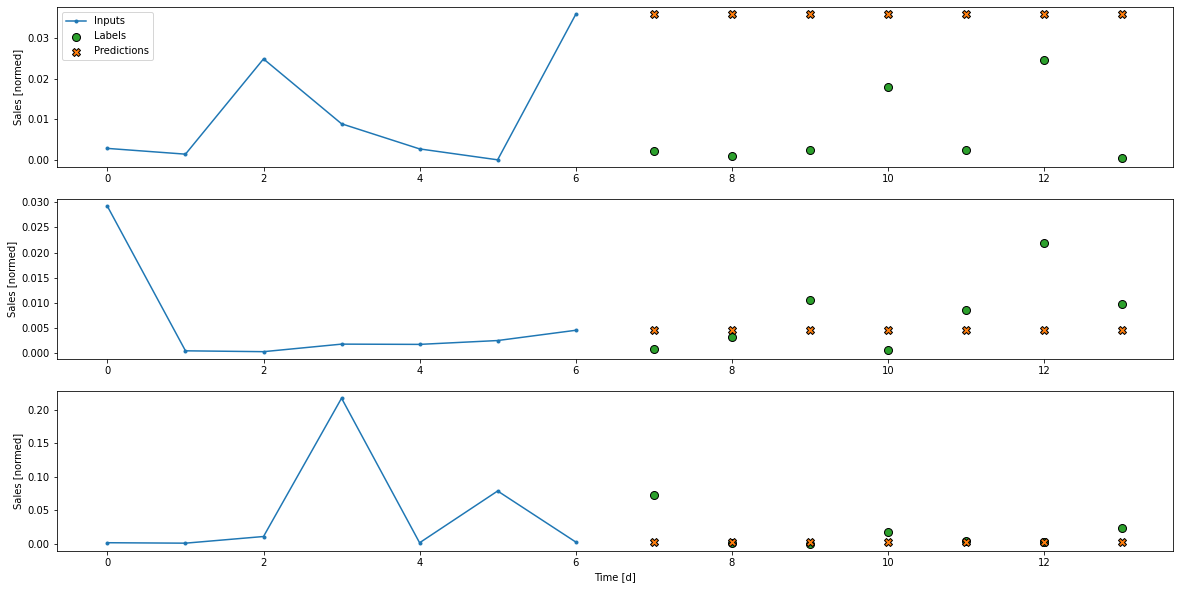

In [56]:
multi_window.plot(
  last_baseline,
  figsize=(20, 10),
  # xlim=(100, 121),
)

### Repeat Baseline

A more "intelligent" approach to the baseline. It repeats the given segment. Based on the thought that the past and present won't be too far off, but can't say for certain.

In [57]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(
  loss=tf.losses.MeanSquaredError(),
  metrics=[tf.metrics.MeanAbsoluteError()]
)

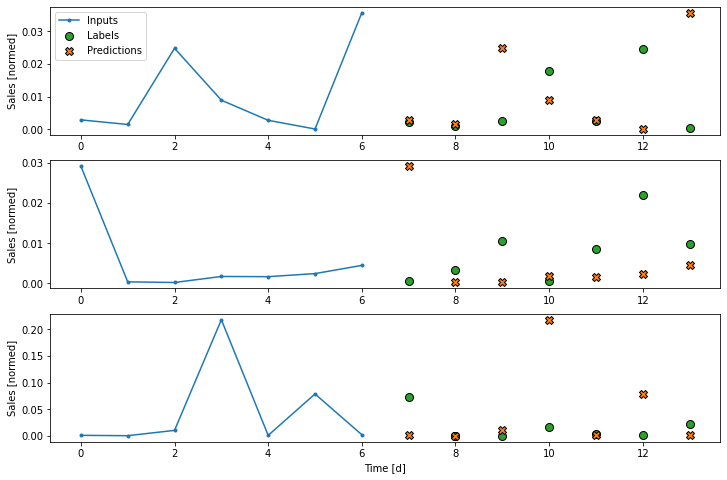

In [58]:
multi_window.plot(repeat_baseline)

### Single-shot

Attempts to solve the problem without hidden layers, quite effective given the simple architecture. A common Neural Network would be like:

```
INPUT -> HIDDEN_LAYER_1 -> HIDDEN_LAYER_2 -> ... -> HIDDEN_LAYER_N -> OUTPUT
```

Whereas the Single-Shot architecture looks something along the lines:

```
INPUT -> OUTPUT
```

The only thing we'll need to handle is to flatten out the input, since it'll be a matrix of vectors, and we'll reshape the output because of the same reasoning.

In [59]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(
      OUT_STEPS * num_features,
      kernel_initializer=tf.initializers.zeros()
    ),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([
      OUT_STEPS,
      num_features,
    ])
])

In [60]:
%time history = compile_and_fit(multi_linear_model, wide_window)

Epoch 1/20
145/145 [==============================] - 2s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0156 - val_loss: 0.0014 - val_mean_absolute_error: 0.0152
Epoch 2/20
145/145 [==============================] - 1s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0156 - val_loss: 0.0014 - val_mean_absolute_error: 0.0158
Epoch 3/20
145/145 [==============================] - 1s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0156 - val_loss: 0.0014 - val_mean_absolute_error: 0.0156
Epoch 4/20
145/145 [==============================] - 1s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0156 - val_loss: 0.0014 - val_mean_absolute_error: 0.0166
CPU times: user 5.45 s, sys: 965 ms, total: 6.42 s
Wall time: 5.25 s


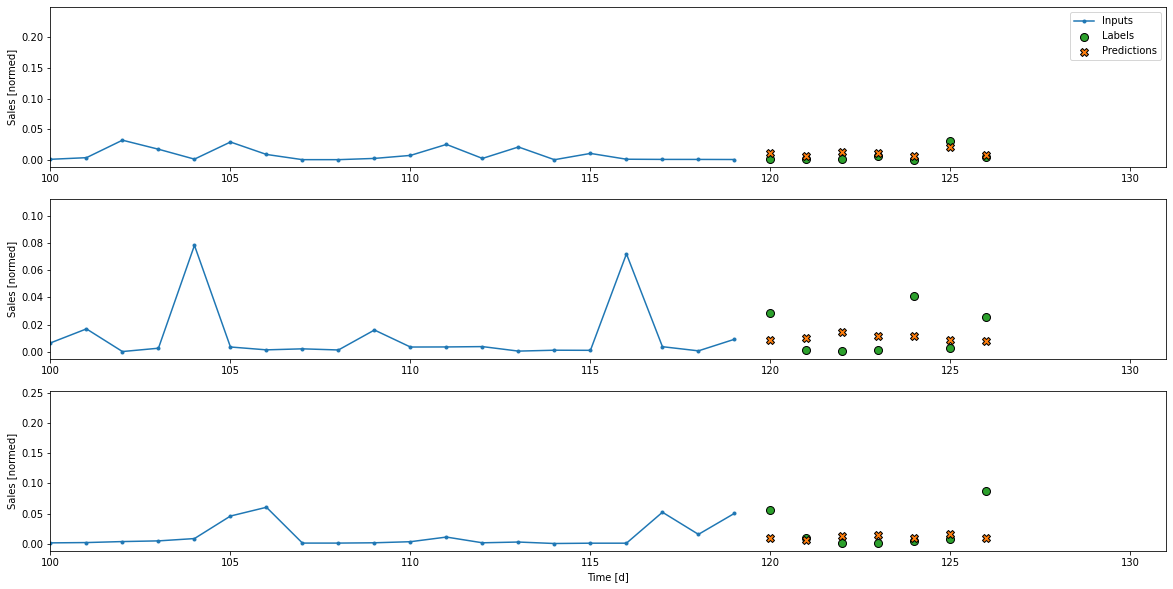

In [61]:
IPython.display.clear_output()
wide_window.plot(
  multi_linear_model,
  figsize=(20, 10),
  # xlim=(100, 121 + OUT_STEPS),
  xlim=(100, 131),
)

### Long Short-Term Memory

LSTM for short, is a Recurrent Neural Network, which means that it's "conscious" of previous records to influence the output.

Let's say we have an array

```python
input = [1, 2, 3, 4, 5]
```

When evaluating the array, each successive number will take into account the values thath the previous neuron already had.

In [62]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(
      x,
      states=state,
      training=training
    )
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [63]:
%time history = compile_and_fit(feedback_model, wide_window)

Epoch 1/20
145/145 [==============================] - 10s 53ms/step - loss: 0.0031 - mean_absolute_error: 0.0320 - val_loss: 0.0017 - val_mean_absolute_error: 0.0219
Epoch 2/20
145/145 [==============================] - 7s 51ms/step - loss: 0.0013 - mean_absolute_error: 0.0188 - val_loss: 0.0015 - val_mean_absolute_error: 0.0190
Epoch 3/20
145/145 [==============================] - 7s 51ms/step - loss: 0.0012 - mean_absolute_error: 0.0170 - val_loss: 0.0014 - val_mean_absolute_error: 0.0177
Epoch 4/20
145/145 [==============================] - 7s 50ms/step - loss: 0.0012 - mean_absolute_error: 0.0163 - val_loss: 0.0014 - val_mean_absolute_error: 0.0172
Epoch 5/20
145/145 [==============================] - 7s 51ms/step - loss: 0.0012 - mean_absolute_error: 0.0159 - val_loss: 0.0014 - val_mean_absolute_error: 0.0172
Epoch 6/20
145/145 [==============================] - 7s 51ms/step - loss: 0.0012 - mean_absolute_error: 0.0157 - val_loss: 0.0014 - val_mean_absolute_error: 0.0173
Epoch 7/2

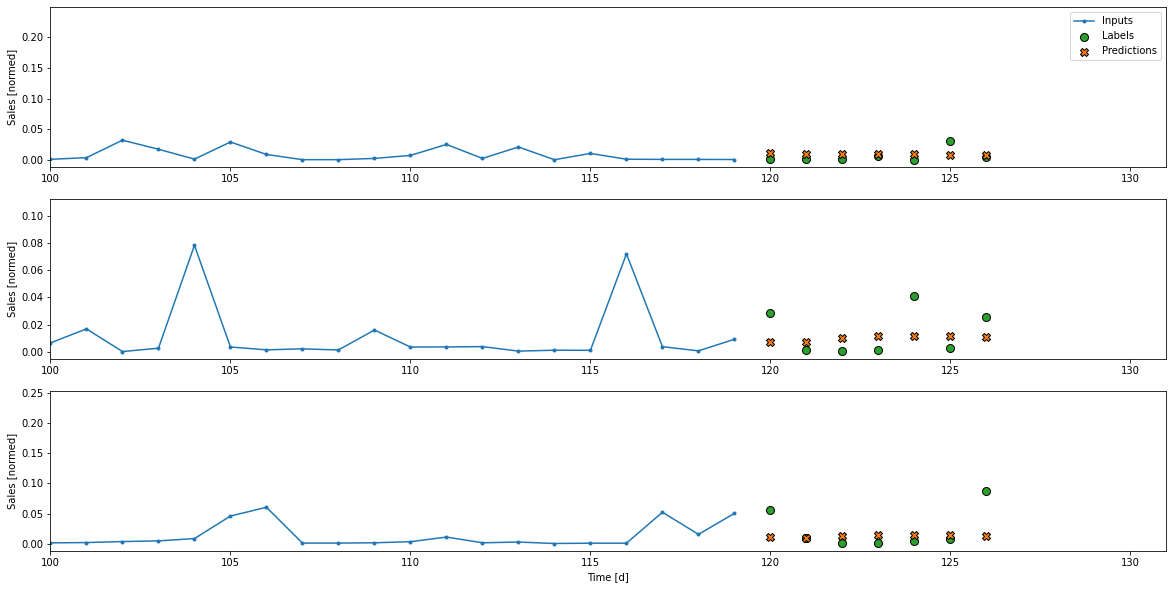

In [64]:
IPython.display.clear_output()

wide_window.plot(
  feedback_model,
  figsize=(20, 10),
  # xlim=(100, 121),
  xlim=(100, 131),
)

## Conclusions

### Timeseries

Timeseries can be tricky, and are. One little mistake can throw off the entire prediction.

Setting the dates up right it's one of the most important things to do right, if not the most, it's actually the most important one. Followed by, early data and it's inconsistency and influence on the future. But more on that later.

### What were we trying to do?

Predict the sales of a superstore given their previous sales over the span of a couple years

#### Cyclic patterns

Detecting any sort of cyclic (repeating) pattern, is a crucial part of a timeseries project. Specially in the exploratory analysis.

Our timeseries model will adapt and learn from those patterns, if there's no pattern at all, it becomes harder for our model to adapt. In this project, no clear pattern was truly detected. But there were some denser points than others, and some minor repeating patterns every now and then.

### Where did we got to?

We got some models that have a kind of good grasp about the feeded data. LSTM is in the lead, which makes total sense. No linear nor convolutional model was attempted since it's not about trying out every single different option, rather, the ones that could and should adequate more.

Tensorflow already did an splendid job at explaining Timeseries and some models in depth and to try out different methods.

But we did got somewhere, and we also saw something funny going on with the dates, more that later.

We could also try to predict the shipping date due to it's distance relative to the order date. But that'd be another challenge, one that I feel too unexperienced to tackle on, but more importantly, one that I feel that serves barely no purpose at all for this project.

But we did get some conclusions outside of the main focus of this project. Which was to predict the sales.

The order date and shipping date, do not follow a pattern, between the time an order has been sent until it's shipped (I'd like to assume, successfully) there's not a fixed amount of time in-between.

Sometimes days pass, others it may be weeks, or months even.

### Why the results weren't accurate?

It is close to reality, but it's only consistent and it's performance whenever there are no spikes, when there's a spike, it does not always adapt to it, nor does it usually do it with the adequate strength.

#### The influence of the past in the future

About timeseries only, not filosophically speaking.

At first, there was an experiment done as to, just having all of the data thrown into the model, how well would it perform. It did not perform well, since, in the beginning of the dataset, there was barely any sales compared to the latest data.

Having data from the start that's not relevant to the present can, and will confuse the model, but it is necessary to have past information, as events are at times but repeating patterns. You just have to be conscious how much past information is fed to the model.

#### Spikes & Inconsistency

To fix inconsistency we could the beginning, when the dataset/supermarket (I can't really tell) was starting to grow, and there's quite the values that could even be irrelevant.

Doing that does improve the model, it does help. But is that all? The spikes are related to some inconsistency, when analyzing the date intervals, there was some information loss, it didn't loop continously, there were gaps. Having gaps in a timeseries reference date is a problem that can be (hot)fixed, but it's a pain.

So, in conclusion, we'd need more information in some areas. One with clearer patterns. But that'd be an ideal world

#### Correlation

We barely had features with a significant (>= 1%) correlation to Sales, there was almost no correlation with the target variable.

Without going over (some say >= ±0.5, others >= ±0.65), the higher the correlation, the better that attribute it may contribute to predict the dependant variable (which in this case was Sales).

And having higher correlated values with the dependant variable can allow us, not only to better predict the value, but to do it with less features, because we're guaranteed a minimum with some features, the less features required for a decent minimum, the faster it performs, so it may not even be worth it having too many features.

To better visualize the impact, let's plot the correlation of the values

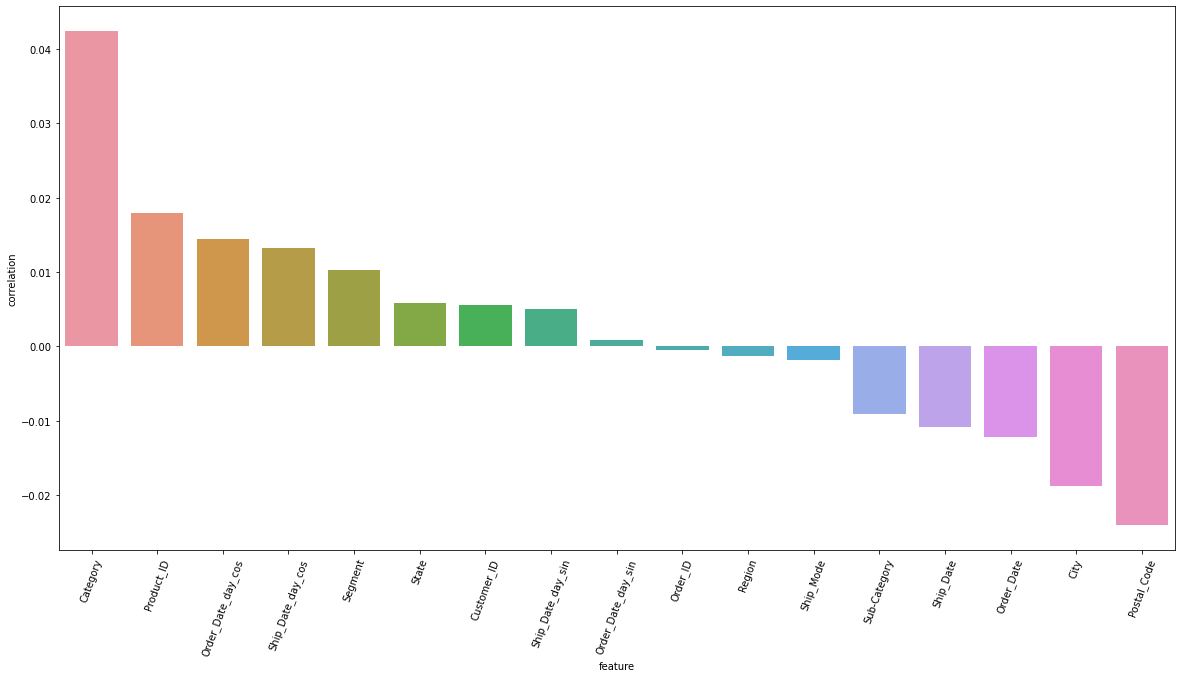

In [65]:
plt.figure(figsize=(20, 10))
df_corr_sales = df.corr()['Sales']
df_corr_sales = pd.DataFrame(list(dict(df_corr_sales).items()), columns=['feature', 'correlation'])
df_corr_sales = df_corr_sales.sort_values(by='correlation', ascending=False)
df_corr_sales = df_corr_sales[1:] # comment for a relative comparison to it's full proportion
plt.xticks(rotation=70)
_ = sns.barplot(data=df_corr_sales, x='feature', y='correlation')

Which amounts to a total correlation of, that's a total right there, not a percentil

In [66]:
df_corr_sales['correlation'].abs().sum()

0.19435363262713246